# PyTorch scaling benchmark analysis

Throughput scaling of PyTorch benchmarks on Cori Haswell with PyTorch distributed and Cray MPI.

In [1]:
import os
import re
import glob

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
plt.rcParams.update({'font.size': 14})

## Utilities

In [4]:
def plot_scaling(ranks, rates, title=None, loglog=False):

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
    
    # Compute ideal scaling relative to lowest rank
    ideal_rates = rates[0] * ranks / ranks[0]

    # Plot throughput scaling
    ax0.plot(ranks, rates, '.-', ms=15, label='measured')
    ax0.plot(ranks, ideal_rates, '--', label='ideal')
    ax0.set_xlabel('Number of workers')
    ax0.set_ylabel('Training throughput [samples/s]')
    if loglog:
        ax0.set_xscale('log')
        ax0.set_yscale('log')
    else:
        ax0.set_ylim(bottom=0)
    ax0.grid()
    ax0.legend(loc=0)

    # Plot the fraction of ideal scaling
    ax1.plot(ranks, rates / ideal_rates, '.-', ms=15)
    ax1.set_xlabel('Number of workers')
    ax1.set_ylabel('Fraction of ideal scaling')
    ax1.grid()
    ax1.set_ylim(bottom=0)
    
    if title is not None:
        ax0.set_title(title)
        ax1.set_title(title)

    plt.tight_layout()
    return fig, ax0, ax1

## Load the results data

In [5]:
ls /global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/

gpu-v1.3.1-nccl-n1/   gpu-v1.3.1-nccl-n2/  gpu-v1.3.1-nccl-n8/
gpu-v1.3.1-nccl-n16/  gpu-v1.3.1-nccl-n4/


In [6]:
results_files = glob.glob('/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n*/results.txt')

results_files

['/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n4/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n2/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n8/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n1/results.txt',
 '/global/cscratch1/sd/sfarrell/pytorch-benchmarks-gpudirect/gpu-v1.3.1-nccl-n16/results.txt']

In [7]:
results = [pd.read_csv(f, delim_whitespace=True) for f in results_files]
results = pd.concat(results, ignore_index=True)

results

,train_rate,inference_rate,ranks,hardware,version,model
0,746.795623,2521.254479,4,gpu-v1.3.1,nccl,inceptionV3
1,20411.779799,49555.526036,4,gpu-v1.3.1,nccl,lstm
2,3113.066946,10497.876586,4,gpu-v1.3.1,nccl,alexnet
3,1065.029337,3591.781826,4,gpu-v1.3.1,nccl,resnet50
4,1267.053378,4152.657392,4,gpu-v1.3.1,nccl,vgg11
5,3365.565952,24497.620922,4,gpu-v1.3.1,nccl,cnn3d
6,376.766656,1269.046318,2,gpu-v1.3.1,nccl,inceptionV3
7,10529.540011,27186.975958,2,gpu-v1.3.1,nccl,lstm
8,1571.787755,5299.732522,2,gpu-v1.3.1,nccl,alexnet
9,543.907613,1800.566535,2,gpu-v1.3.1,nccl,resnet50


## Training throughput scaling

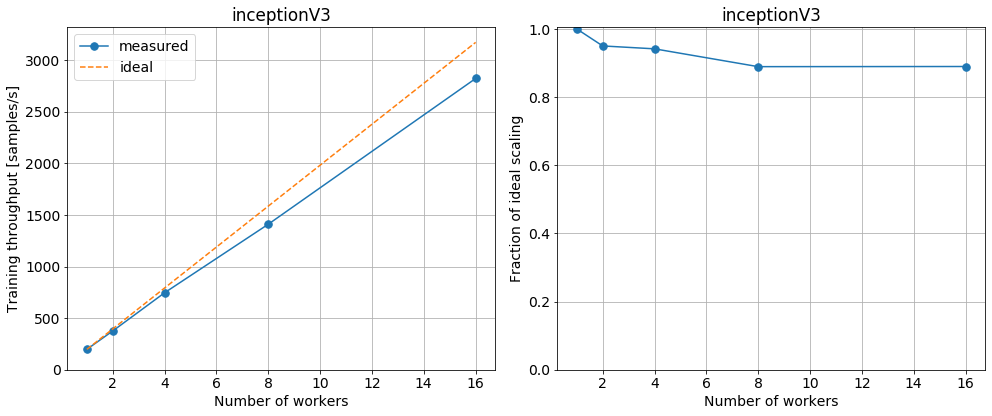

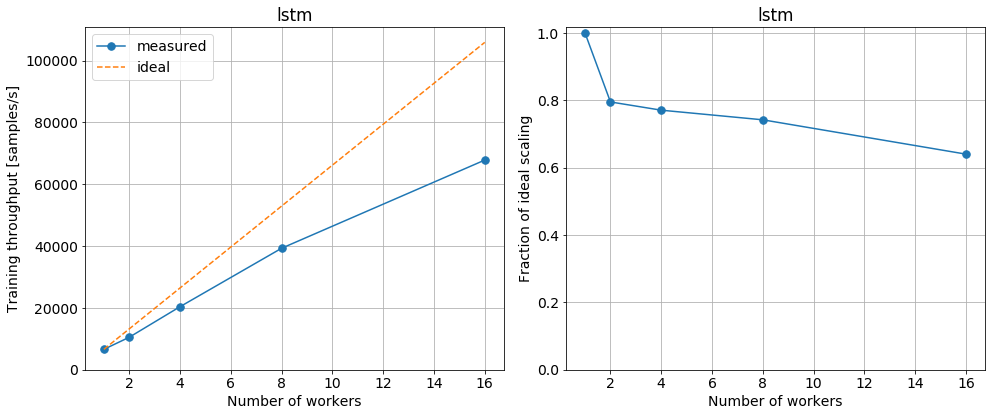

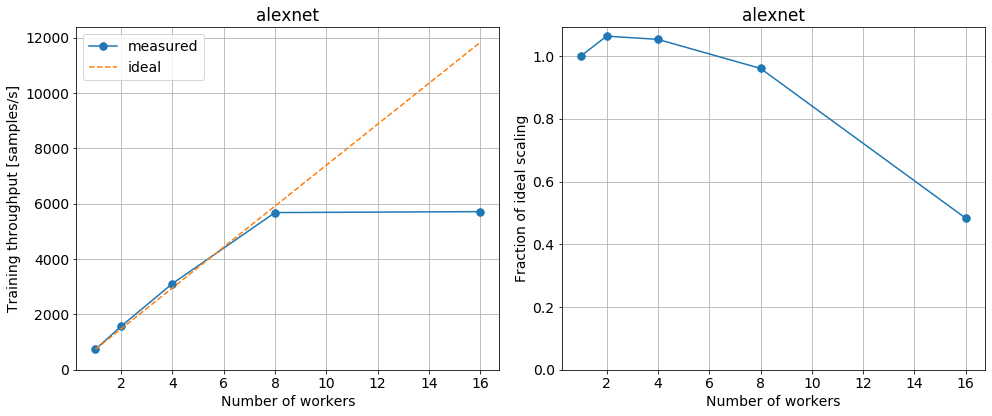

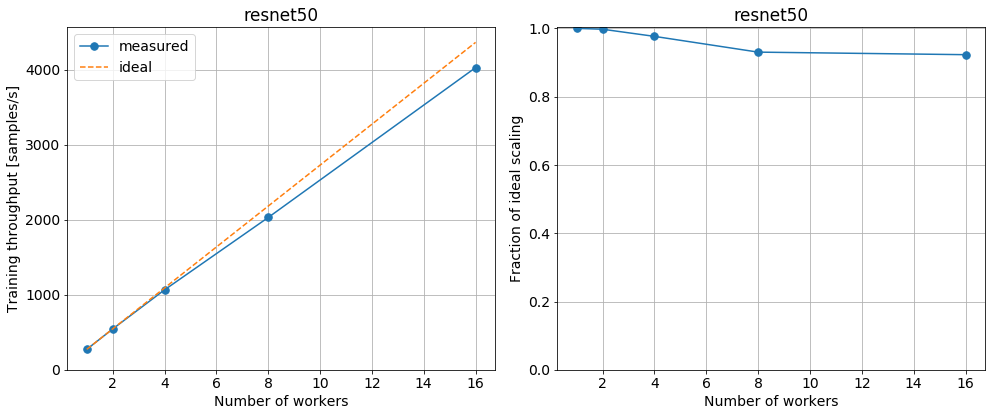

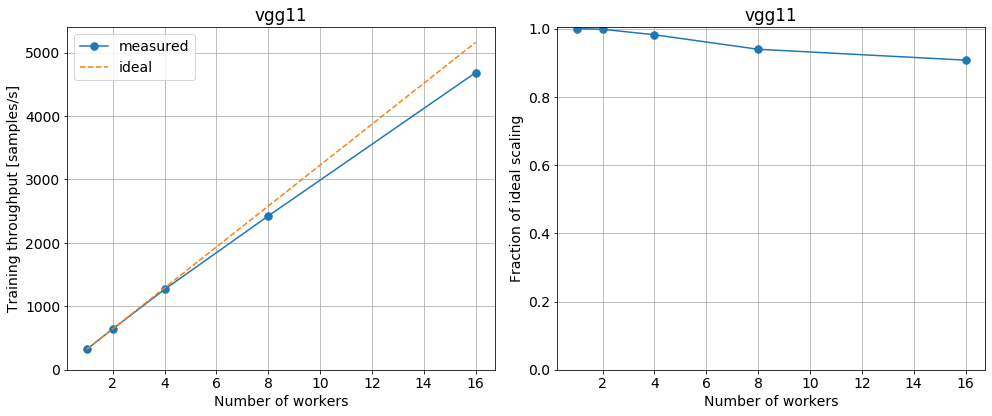

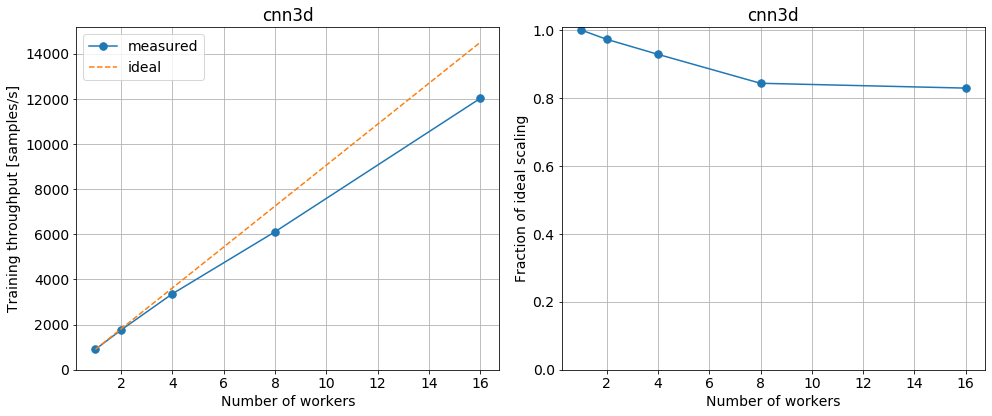

In [8]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.train_rate.values,
                                 title=model)

## Inference throughput scaling

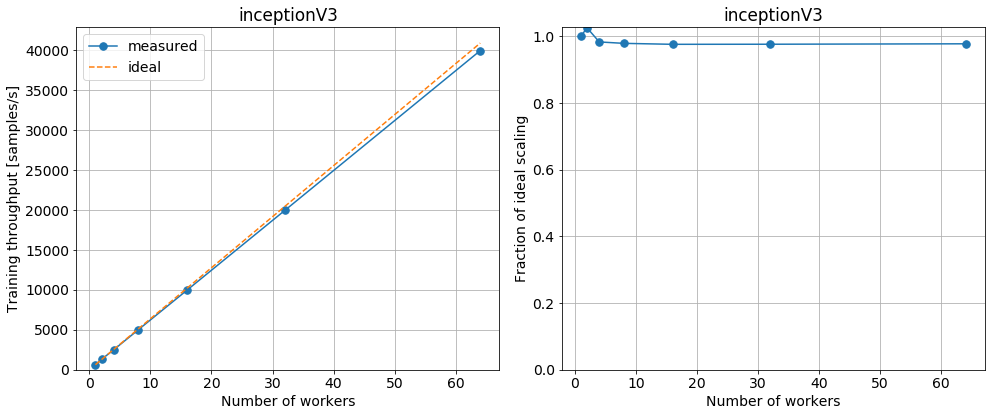

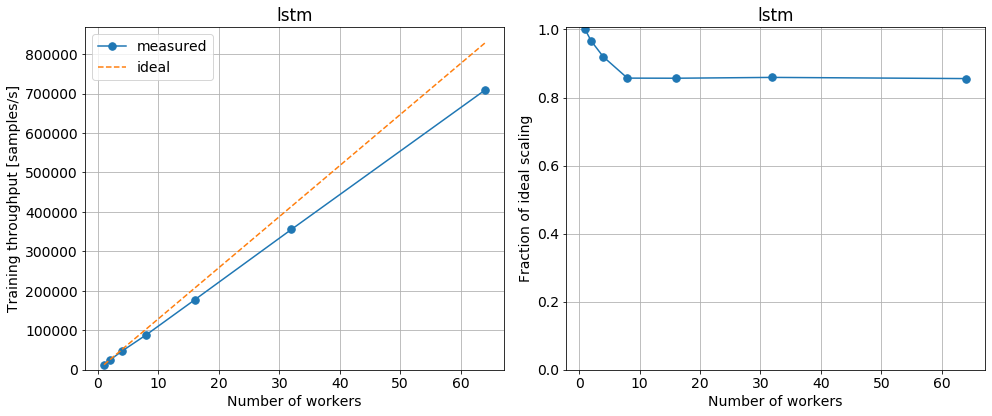

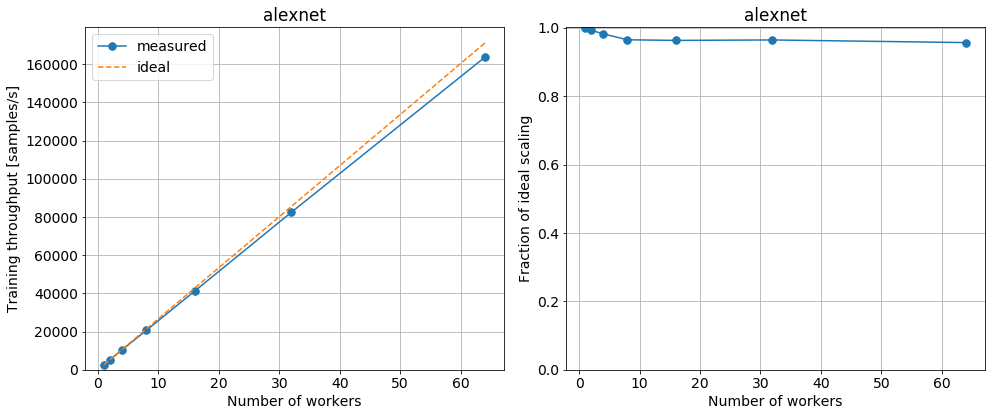

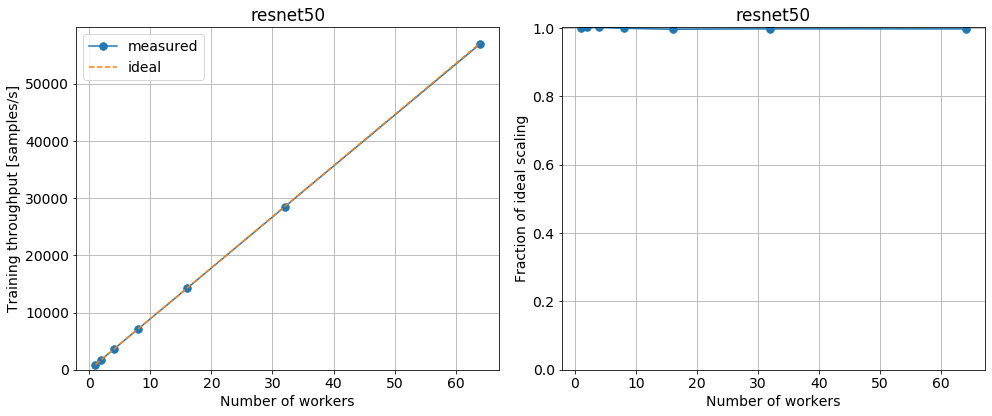

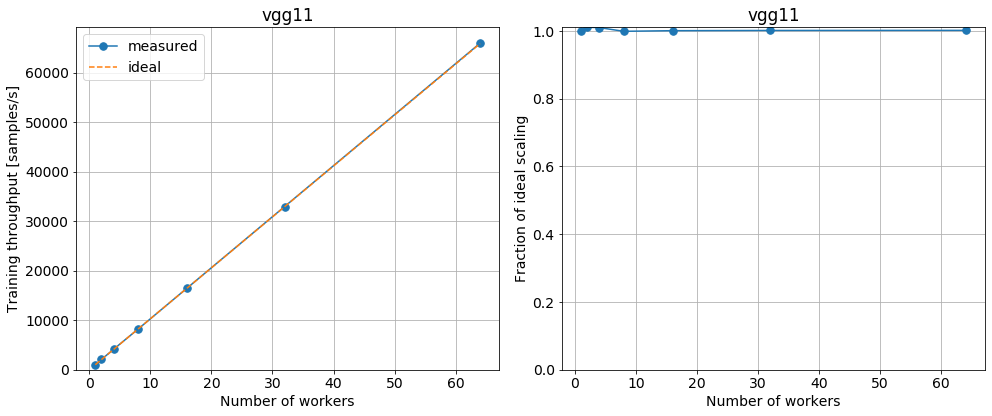

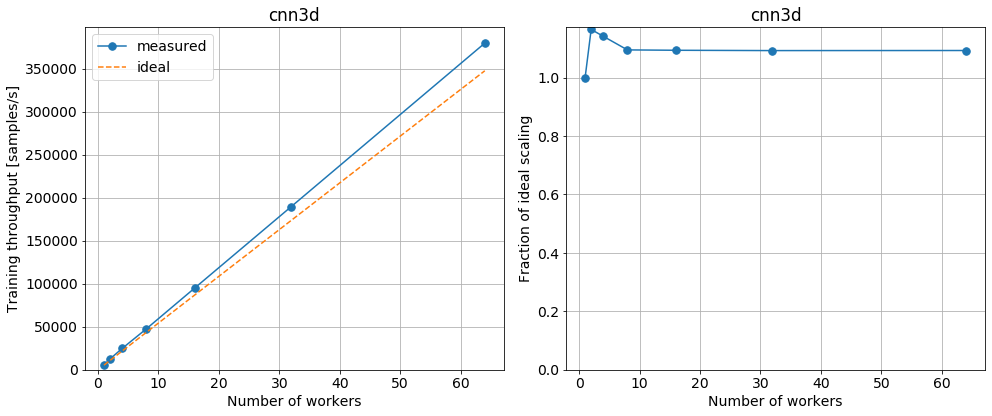

In [40]:
for model in results.model.unique():
    model_results = results[results.model == model].sort_values('ranks')
    fig, ax0, ax1 = plot_scaling(model_results.ranks.values,
                                 model_results.inference_rate.values,
                                 title=model)